<a href="https://colab.research.google.com/github/MohamedSouilhi/Beauty-parlor-management-system/blob/main/Lung_Cancer_Image_Segmentation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!unzip /content/archive.zip -d /content/

Archive:  /content/archive.zip
  inflating: /content/data/test/images/images_0.npy  
  inflating: /content/data/test/images/images_1.npy  
  inflating: /content/data/test/images/images_10.npy  
  inflating: /content/data/test/images/images_100.npy  
  inflating: /content/data/test/images/images_101.npy  
  inflating: /content/data/test/images/images_102.npy  
  inflating: /content/data/test/images/images_103.npy  
  inflating: /content/data/test/images/images_104.npy  
  inflating: /content/data/test/images/images_105.npy  
  inflating: /content/data/test/images/images_106.npy  
  inflating: /content/data/test/images/images_107.npy  
  inflating: /content/data/test/images/images_108.npy  
  inflating: /content/data/test/images/images_109.npy  
  inflating: /content/data/test/images/images_11.npy  
  inflating: /content/data/test/images/images_110.npy  
  inflating: /content/data/test/images/images_111.npy  
  inflating: /content/data/test/images/images_112.npy  
  inflating: /content/d

In [4]:
# Importations nécessaires
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Multiply, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from skimage import morphology

# 1. Chargement des données

In [5]:
def load_data(image_dir, mask_dir):
    images, masks = [], []
    for file in os.listdir(image_dir):
        img_file_path = os.path.join(image_dir, file)
        mask_file_path = os.path.join(mask_dir, file.replace('images', 'masks'))  # Assuming corresponding masks have similar naming

        if os.path.exists(mask_file_path):
            image = np.load(img_file_path)
            mask = np.load(mask_file_path)
            images.append(cv2.resize(image, (256, 256)))
            masks.append(cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST))
        else:
            print(f"Skipping {img_file_path} due to missing mask.")

    if len(images) == 0 or len(masks) == 0:
        print(f"Warning: No images or masks found in {image_dir}. Returning empty arrays.")
        return np.empty((0, 256, 256)), np.empty((0, 256, 256))

    return np.array(images), np.array(masks)




In [6]:
train_image_dir = "/content/data/train/images"
train_mask_dir = "/content/data/train/labels"
test_image_dir = "/content/data/test/images"
test_mask_dir = "/content/data/test/labels"
val_image_dir = "/content/data/val/images"
val_mask_dir = "/content/data/val/labels"

In [7]:
# Charger les données
X_train, y_train = load_data(train_image_dir, train_mask_dir)
X_test, y_test = load_data(test_image_dir, test_mask_dir)
X_val, y_val = load_data(val_image_dir, val_mask_dir)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((1446, 256, 256),
 (1446, 256, 256),
 (162, 256, 256),
 (162, 256, 256),
 (162, 256, 256),
 (162, 256, 256))

In [9]:
# Ajouter une dimension pour le canal (nécessaire pour les modèles de CNN)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)


# 1. Fonctions de perte avancees

In [10]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - dice

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        return -K.sum(alpha * K.pow(1. - pt, gamma) * K.log(pt))
    return focal_loss_fixed


# 3. Définition du modèle U-Net avec mécanisme d'attention


LBF

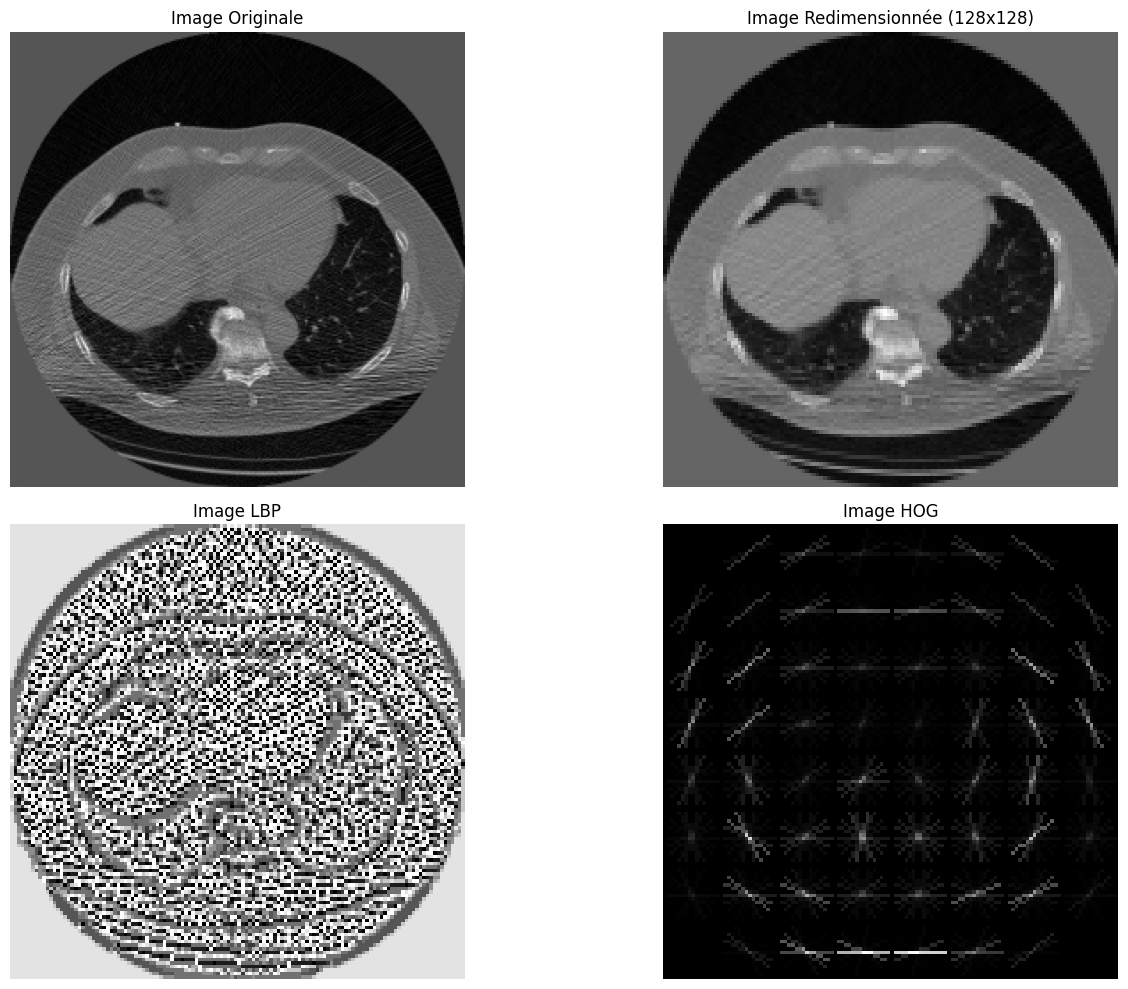

In [17]:
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog
from skimage.transform import resize

# Fonctions pour extraire les caractéristiques
def extract_lbp_features(image, radius=1, n_points=8):
    """Extrait les caractéristiques LBP."""
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    return lbp

def extract_hog_features(image):
    """Extrait les caractéristiques HOG."""
    features, hog_image = hog(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True, channel_axis=None)
    return hog_image

# Charger une image de l'ensemble d'entraînement
sample_image = X_train[0].squeeze()  # Supprimer la dimension du canal si nécessaire

# Redimensionner l'image
sample_image_resized = resize(sample_image, (128, 128), anti_aliasing=True)

# Calculer les LBP
lbp_image = extract_lbp_features(sample_image_resized)

# Calculer les HOG
hog_image = extract_hog_features(sample_image_resized)

# Afficher les images
plt.figure(figsize=(15, 10))

# Image originale
plt.subplot(2, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Image Originale")
plt.axis('off')

# Image redimensionnée
plt.subplot(2, 2, 2)
plt.imshow(sample_image_resized, cmap='gray')
plt.title("Image Redimensionnée (128x128)")
plt.axis('off')

# Image LBP
plt.subplot(2, 2, 3)
plt.imshow(lbp_image, cmap='gray')
plt.title("Image LBP")
plt.axis('off')

# Image HOG
plt.subplot(2, 2, 4)
plt.imshow(hog_image, cmap='gray')
plt.title("Image HOG")
plt.axis('off')

plt.tight_layout()
plt.show()

Unet

In [18]:
def attention_block(input_tensor, skip_tensor, filters):
    g = Conv2D(filters, 1, padding='same')(input_tensor)
    x = Conv2D(filters, 1, padding='same')(skip_tensor)
    attention = Add()([g, x])
    attention = Conv2D(1, 1, activation='sigmoid', padding='same')(attention)
    return Multiply()([skip_tensor, attention])

**----------------------------------------------------------------------------------**

In [19]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Multiply, Add
from tensorflow.keras.models import Model



def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


# Créer le modèle
model = unet_model(input_size=(256, 256, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 1024)   │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1536)   │              0 │ up_sampling2d[0][0],   │
│                      

 Total params: 31,377,793 (119.70 MB)

 Trainable params: 31,377,793 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Compilation du modèle avec Dice Loss


# 5. Callbacks pour un meilleur entraînement


In [20]:
callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model.keras', verbose=1, save_best_only=True) # Changed the file extension to .keras
]

# 6. Entraînement du modèle


In [33]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.9970 - loss: 0.0197
Epoch 1: val_loss improved from 0.01685 to 0.01600, saving model to best_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 70s 771ms/step - accuracy: 0.9970 - loss: 0.0197 - val_accuracy: 0.9976 - val_loss: 0.0160 - learning_rate: 0.0010
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.9970 - loss: 0.0171
Epoch 2: val_loss improved from 0.01600 to 0.01291, saving model to best_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 87s 827ms/step - accuracy: 0.9970 - loss: 0.0170 - val_accuracy: 0.9976 - val_loss: 0.0129 - learning_rate: 0.0010
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.9972 - loss: 0.0146
Epoch 3: val_loss improved from 0.01291 to 0.01183, saving model to best_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 82s 829ms/step - accuracy: 0.9972 - loss: 0.0146 - val_accuracy: 0.9976 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accurac

# 7. Évaluation du modèle


In [34]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.9999 - loss: 3.4333e-04
Test Loss: 0.00034298188984394073, Test Accuracy: 0.9998634457588196


# 8. Prédiction et visualisation


In [35]:
predictions = model.predict(X_test)

def plot_results(image, mask, prediction, threshold=0.5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image.squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Masque Réel")
    plt.imshow(mask.squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prédiction")
    plt.imshow((prediction.squeeze() > threshold).astype(np.uint8), cmap='gray')
    plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step


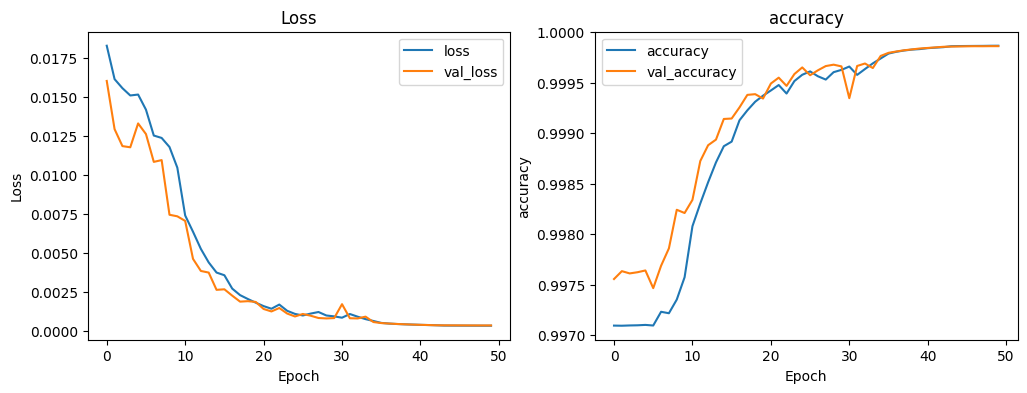

In [46]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

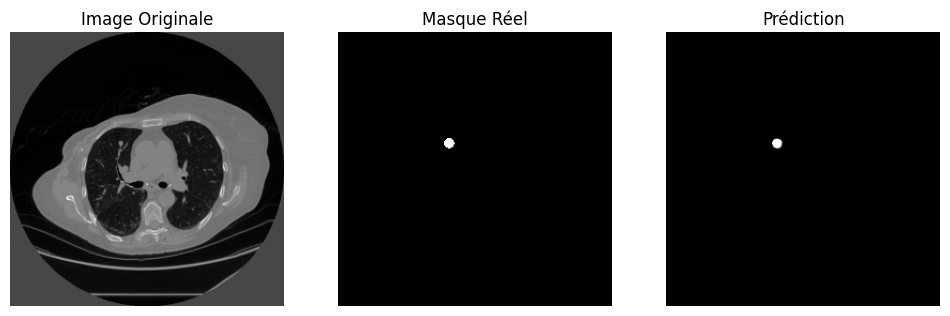

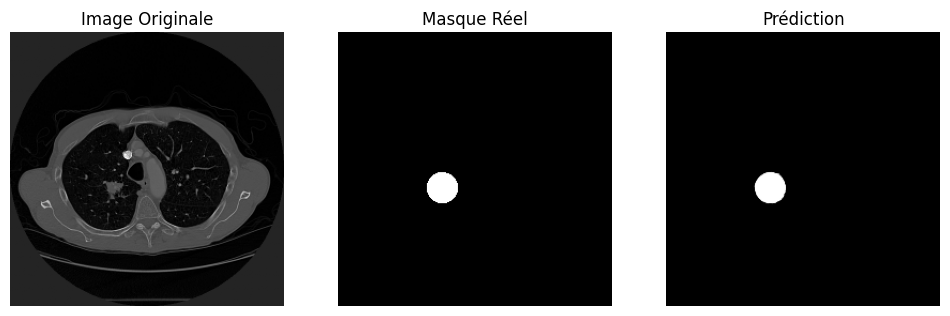

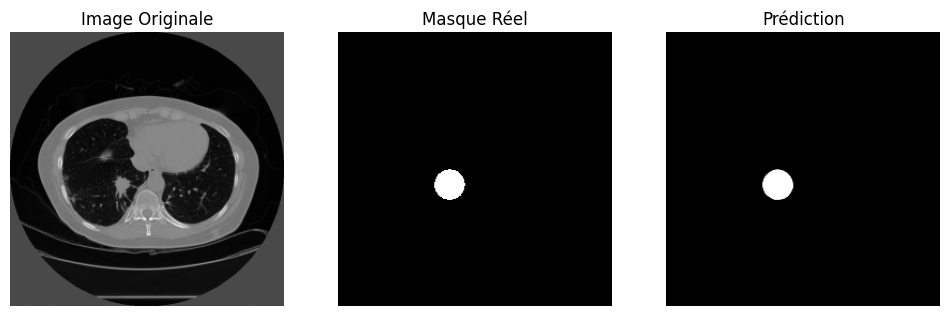

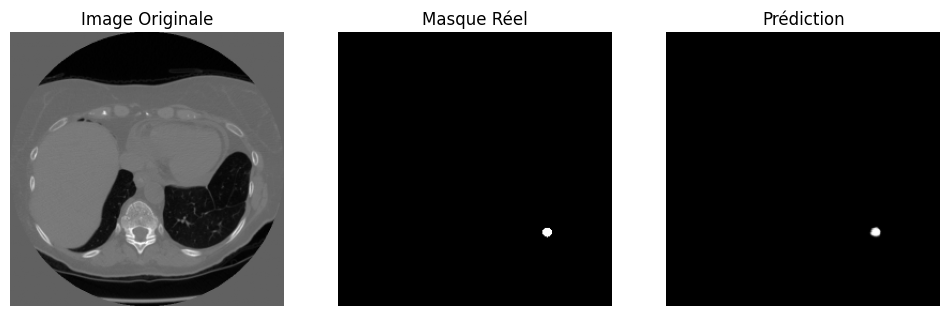

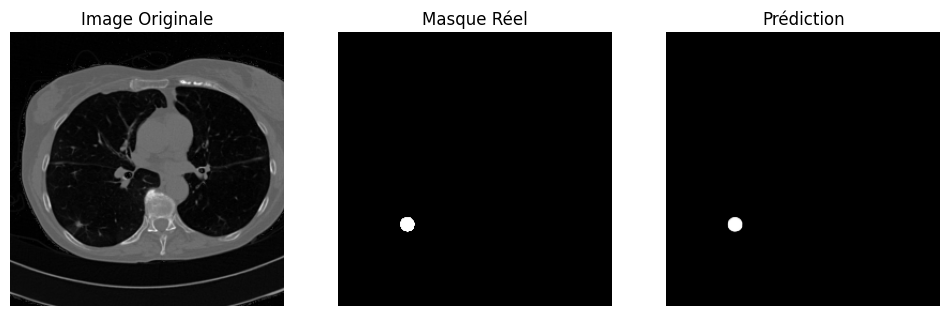

In [36]:
import matplotlib.pyplot as plt

def plot_results(image, true_mask, predicted_mask):
    plt.figure(figsize=(12, 4))

    # Image originale
    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title("Image Originale")
    plt.axis('off')

    # Masque réel
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title("Masque Réel")
    plt.axis('off')

    # Prédiction
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title("Prédiction")
    plt.axis('off')

    plt.show()

# Afficher les résultats pour 5 images
for i in range(5):
    plot_results(X_test[i], y_test[i], predictions[i])

# 9. Post-traitement des prédictions

In [37]:
def postprocess(prediction, threshold=0.5, min_size=50):
    binary = (prediction > threshold).astype(np.uint8)
    cleaned = morphology.remove_small_objects(binary, min_size=min_size)
    cleaned = morphology.remove_small_holes(cleaned, area_threshold=min_size)
    return cleaned

In [38]:
cleaned_predictions = [postprocess(pred) for pred in predictions]


<ipython-input-37-1a9943ee8a16>:3: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  cleaned = morphology.remove_small_objects(binary, min_size=min_size)
<ipython-input-37-1a9943ee8a16>:4: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  cleaned = morphology.remove_small_holes(cleaned, area_threshold=min_size)


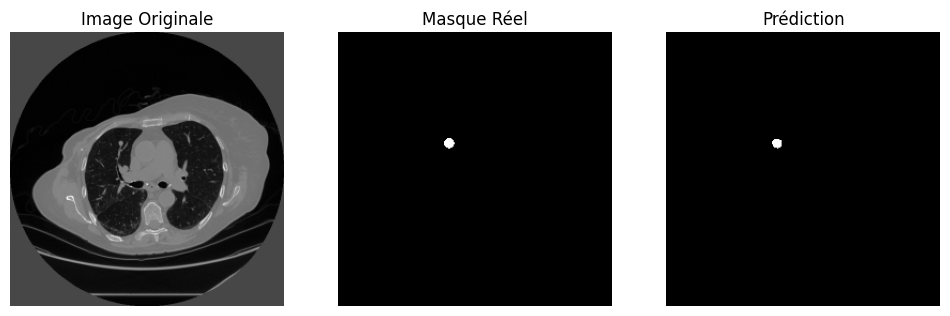

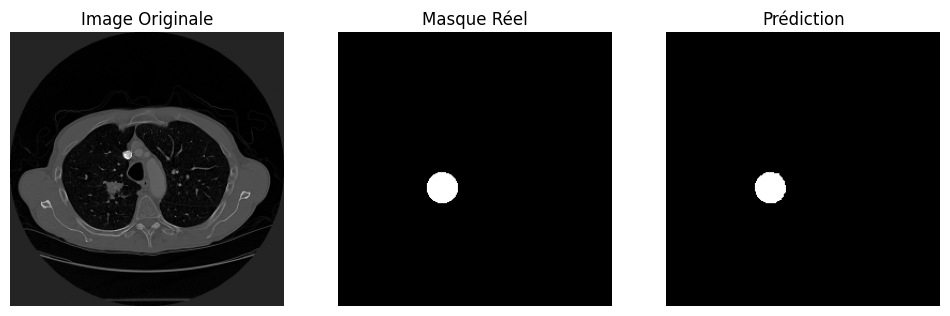

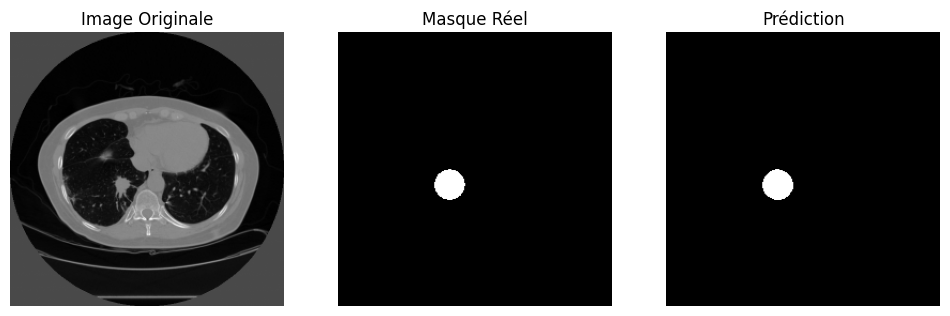

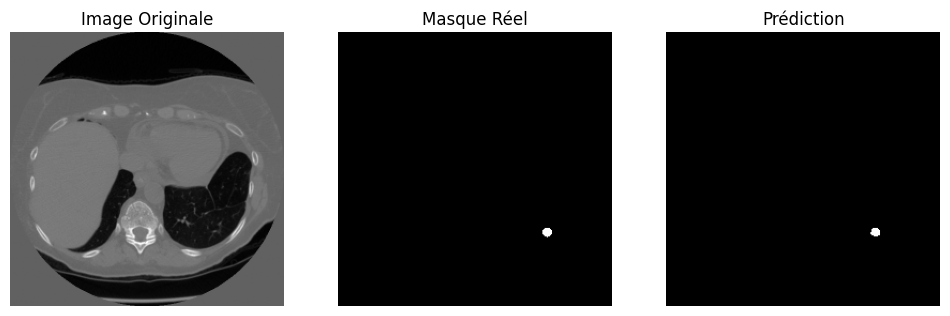

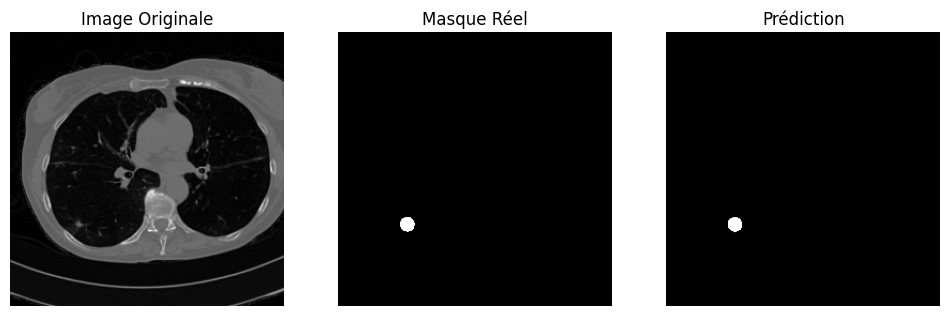

In [39]:
import matplotlib.pyplot as plt

def plot_results(image, true_mask, predicted_mask):
    plt.figure(figsize=(12, 4))

    # Image originale
    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title("Image Originale")
    plt.axis('off')

    # Masque réel
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title("Masque Réel")
    plt.axis('off')

    # Prédiction
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title("Prédiction")
    plt.axis('off')

    plt.show()

# Afficher les résultats pour 5 images
for i in range(5):
    plot_results(X_test[i], y_test[i], cleaned_predictions[i])